In [1]:
import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image

In [2]:
IMG_DIR = '/Users/sebastian/University/Master/second_term/cil/road-segmentation/data/training/images/'

In [3]:
TEST_DIR = '/Users/sebastian/University/Master/second_term/cil/road-segmentation/data/test/images/'

Processing images: 100%|█████████████████████| 144/144 [00:00<00:00, 166.39it/s]


(array([ 1,  2,  1,  2, 10,  2,  8,  6,  9,  8,  5,  5,  2,  5,  2,  1,  5,
        2,  5,  6,  6,  8, 11, 12, 11,  2,  2,  3,  1,  1]), array([ 72.375525,  76.22703 ,  80.078535,  83.93004 ,  87.781545,
        91.63305 ,  95.484555,  99.33606 , 103.187565, 107.03907 ,
       110.890575, 114.74208 , 118.593585, 122.44509 , 126.296595,
       130.1481  , 133.999605, 137.85111 , 141.702615, 145.55412 ,
       149.405625, 153.25713 , 157.108635, 160.96014 , 164.811645,
       168.66315 , 172.514655, 176.36616 , 180.217665, 184.06917 ,
       187.920675]))


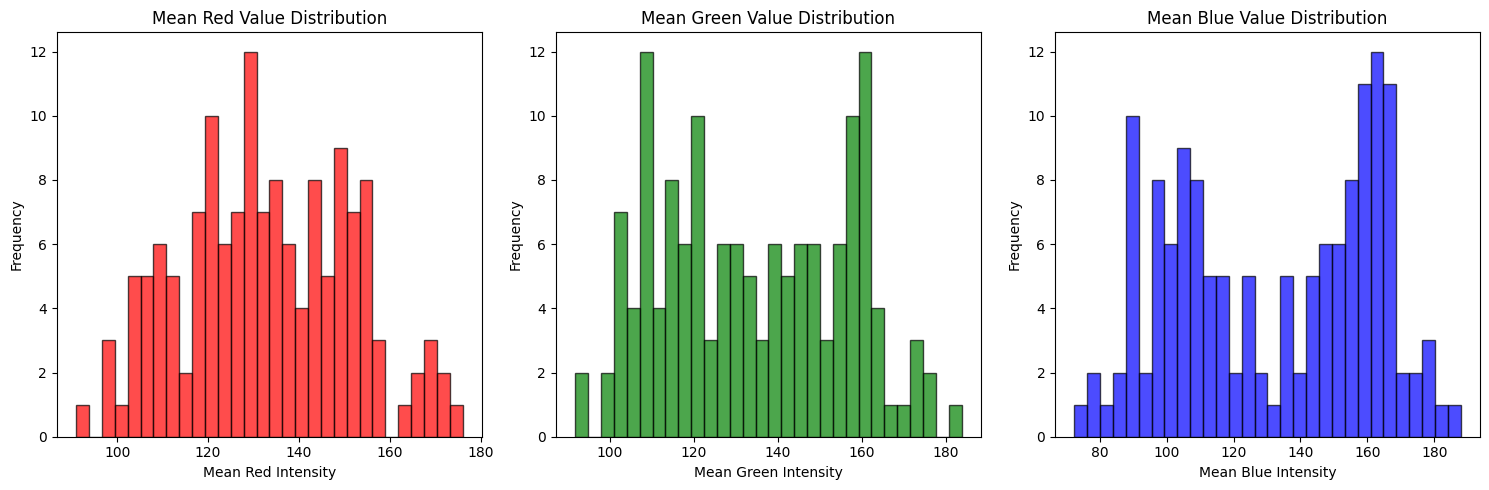

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_mean_rgb(image):
    """Calculate mean RGB values for a given image."""
    return np.mean(image, axis=(0, 1))

def plot_rgb_distribution(image_dir, num_bins=30):
    # Lists to store mean RGB values
    mean_r_values = []
    mean_g_values = []
    mean_b_values = []

    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')]

    for img_file in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        # Calculate mean RGB values
        mean_r, mean_g, mean_b = calculate_mean_rgb(img)
        mean_r_values.append(mean_r)
        mean_g_values.append(mean_g)
        mean_b_values.append(mean_b)
    print(np.histogram(mean_b_values, bins=30))
    # Create histograms
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(mean_r_values, bins=num_bins, color='red', edgecolor='black', alpha=0.7)
    plt.title('Mean Red Value Distribution')
    plt.xlabel('Mean Red Intensity')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(mean_g_values, bins=num_bins, color='green', edgecolor='black', alpha=0.7)
    plt.title('Mean Green Value Distribution')
    plt.xlabel('Mean Green Intensity')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(mean_b_values, bins=num_bins, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Mean Blue Value Distribution')
    plt.xlabel('Mean Blue Intensity')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Usage
image_directory = TEST_DIR
plot_rgb_distribution(image_directory)


Processing images: 100%|█████████████████████| 144/144 [00:01<00:00, 108.18it/s]


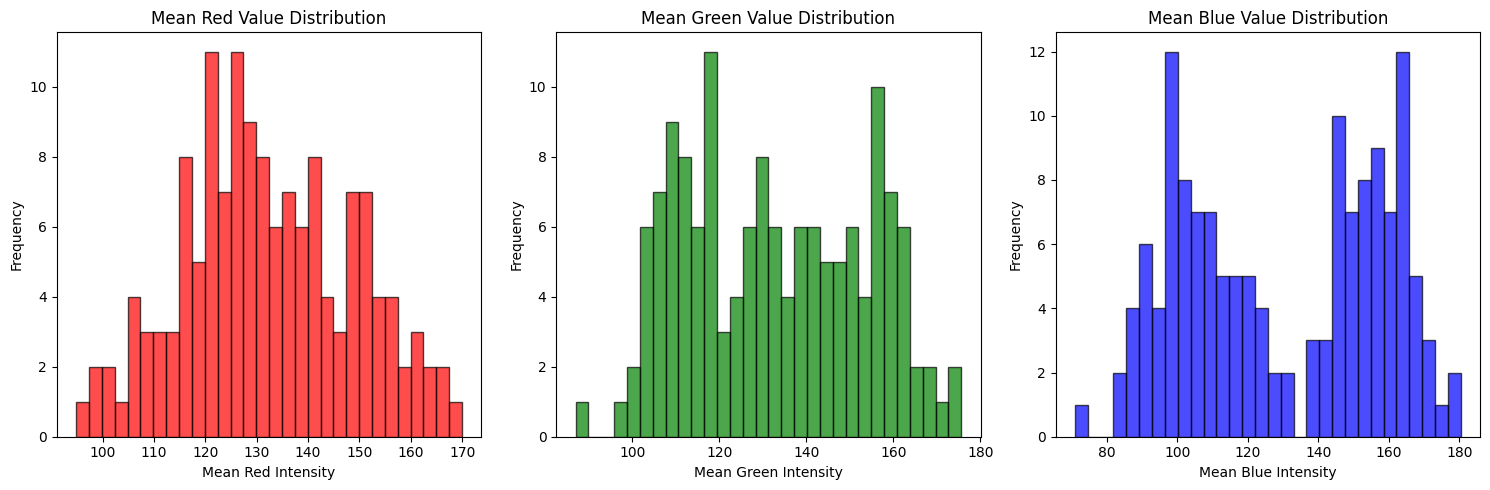

In [8]:
plot_rgb_distribution(IMG_DIR+ "eth")

Processing images: 100%|█████████████████████| 100/100 [00:00<00:00, 115.78it/s]


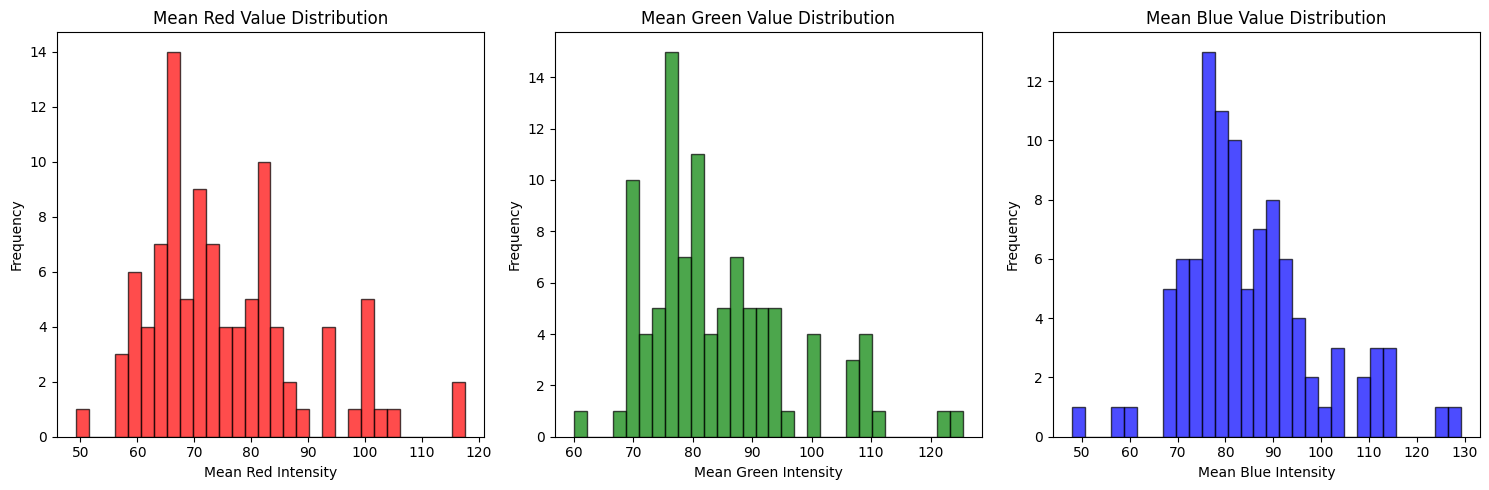

In [9]:
plot_rgb_distribution(IMG_DIR+ "epfl")

Processing images: 100%|███████████████████| 3750/3750 [00:29<00:00, 125.76it/s]


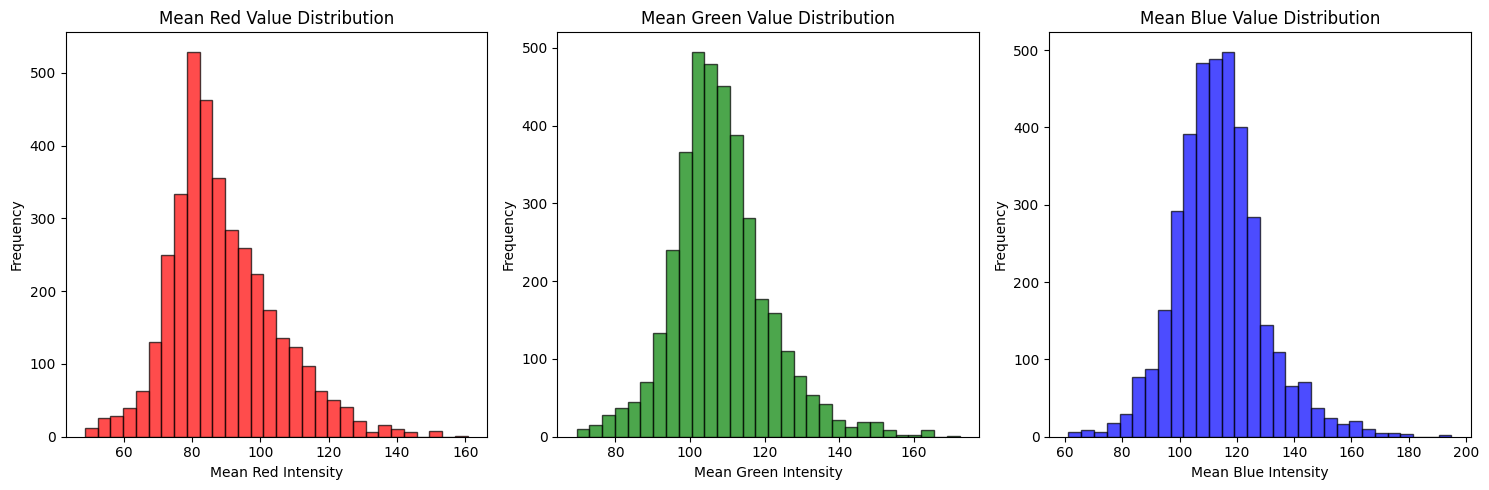

In [23]:
plot_rgb_distribution(IMG_DIR+ "deepglobe_filtered")

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_mean_rgb(image):
    """Calculate mean RGB values for a given image."""
    return np.mean(image, axis=(0, 1))

def match_rgb_distribution(reference_dir, external_dir, num_bins=30):
    # Calculate mean RGB for reference images
    reference_means = []
    for img_file in os.listdir(reference_dir):
        if img_file.endswith('.png') or img_file.endswith('.jpg'):
            img_path = os.path.join(reference_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                reference_means.append(calculate_mean_rgb(img))
    reference_means = np.array(reference_means)

    # Calculate mean RGB for external images
    external_means = []
    external_files = []
    for img_file in os.listdir(external_dir):
        if img_file.endswith('.png') or img_file.endswith('.jpg'):
            img_path = os.path.join(external_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                external_means.append(calculate_mean_rgb(img))
                external_files.append(img_file)
    external_means = np.array(external_means)

    # Binning
    r_bins = np.linspace(0, 255, num_bins + 1)
    g_bins = np.linspace(0, 255, num_bins + 1)
    b_bins = np.linspace(0, 255, num_bins + 1)

    # Counting in reference dataset
    ref_hist, _ = np.histogramdd(reference_means, bins=[r_bins, g_bins, b_bins])
    ref_hist = ref_hist / ref_hist.sum()  # Normalize to get proportions

    # Counting in external dataset
    ext_hist, _ = np.histogramdd(external_means, bins=[r_bins, g_bins, b_bins])

    # Select images based on reference distribution
    selected_files = []
    for (r_idx, g_idx, b_idx), count in np.ndenumerate(ext_hist):
        # Number of images to select from external data
        num_to_select = int(ref_hist[r_idx, g_idx, b_idx] * ext_hist.sum())
        if num_to_select > 0:
            # Get indices of images in the current bin
            bin_indices = np.where(
                (r_bins[r_idx] <= external_means[:, 0]) & (external_means[:, 0] < r_bins[r_idx + 1]) &
                (g_bins[g_idx] <= external_means[:, 1]) & (external_means[:, 1] < g_bins[g_idx + 1]) &
                (b_bins[b_idx] <= external_means[:, 2]) & (external_means[:, 2] < b_bins[b_idx + 1])
            )[0]
            # Randomly select num_to_select indices
            selected_indices = np.random.choice(bin_indices, min(num_to_select, len(bin_indices)), replace=False)
            selected_files.extend([external_files[i] for i in selected_indices])

    return selected_files

# Usage
reference_directory = TEST_DIR
external_directory = IMG_DIR + "deepglobe_filtered"
selected_images = match_rgb_distribution(reference_directory, external_directory, num_bins=30)

print("Selected images:", selected_images)


Selected images: ['dg_42399_sat_0.png', 'dg_232039_sat_3.png', 'dg_295482_sat_1.png', 'dg_709100_sat_2.png', 'dg_29952_sat_1.png', 'dg_86801_sat_3.png', 'dg_655291_sat_0.png', 'dg_98157_sat_1.png', 'dg_527572_sat_7.png', 'dg_779760_sat_6.png', 'dg_574494_sat_3.png', 'dg_325890_sat_6.png', 'dg_863399_sat_6.png', 'dg_99913_sat_2.png', 'dg_866782_sat_1.png', 'dg_86801_sat_1.png', 'dg_64343_sat_3.png', 'dg_36626_sat_3.png', 'dg_697488_sat_2.png', 'dg_769104_sat_8.png', 'dg_360726_sat_7.png', 'dg_752601_sat_0.png', 'dg_688218_sat_1.png', 'dg_636013_sat_2.png', 'dg_638100_sat_6.png', 'dg_245951_sat_5.png', 'dg_356917_sat_0.png', 'dg_186840_sat_2.png', 'dg_98157_sat_2.png', 'dg_158296_sat_1.png', 'dg_111202_sat_1.png', 'dg_529100_sat_7.png', 'dg_180197_sat_5.png', 'dg_235133_sat_6.png', 'dg_797036_sat_4.png', 'dg_131094_sat_4.png', 'dg_559237_sat_0.png', 'dg_401529_sat_6.png', 'dg_768086_sat_7.png', 'dg_649400_sat_5.png', 'dg_48845_sat_3.png', 'dg_25459_sat_7.png', 'dg_64398_sat_7.png', 'dg_1

In [15]:
def plot_rgb_distributio2(image_dir, image_files, num_bins=30):
    # Lists to store mean RGB values
    mean_r_values = []
    mean_g_values = []
    mean_b_values = []

    for img_file in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        # Calculate mean RGB values
        mean_r, mean_g, mean_b = calculate_mean_rgb(img)
        mean_r_values.append(mean_r)
        mean_g_values.append(mean_g)
        mean_b_values.append(mean_b)

    # Create histograms
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(mean_r_values, bins=num_bins, color='red', edgecolor='black', alpha=0.7)
    plt.title('Mean Red Value Distribution')
    plt.xlabel('Mean Red Intensity')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(mean_g_values, bins=num_bins, color='green', edgecolor='black', alpha=0.7)
    plt.title('Mean Green Value Distribution')
    plt.xlabel('Mean Green Intensity')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(mean_b_values, bins=num_bins, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Mean Blue Value Distribution')
    plt.xlabel('Mean Blue Intensity')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

Processing images: 100%|█████████████████████| 261/261 [00:02<00:00, 128.34it/s]


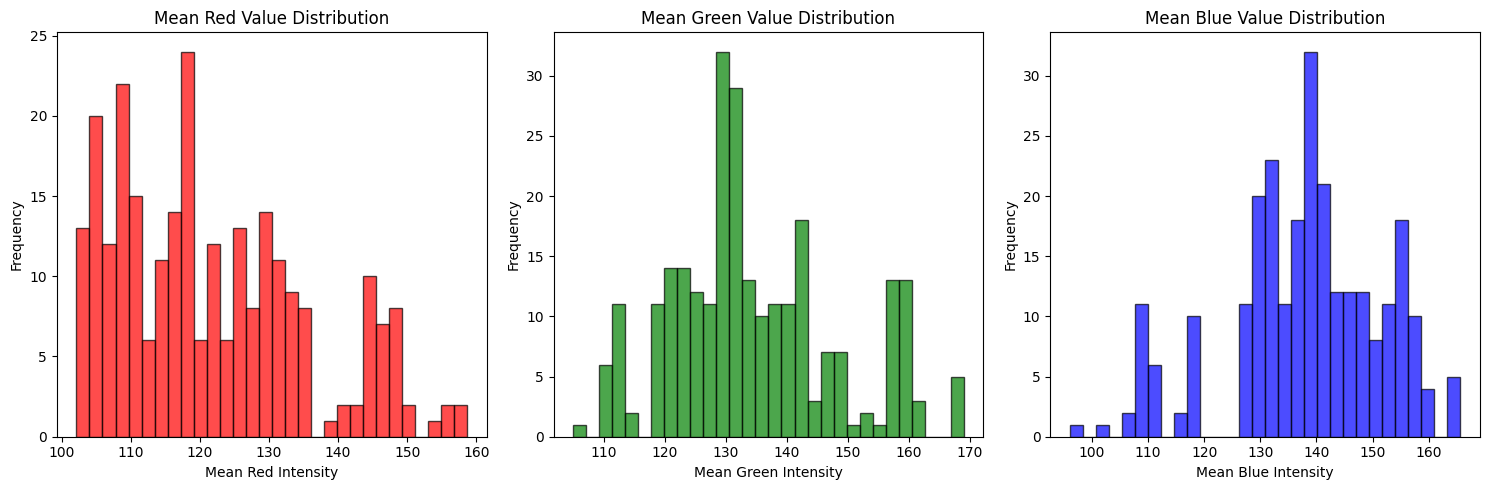

In [17]:
plot_rgb_distributio2(IMG_DIR+"deepglobe_filtered",selected_images)

In [21]:
selected_images

['dg_42399_sat_0.png',
 'dg_232039_sat_3.png',
 'dg_295482_sat_1.png',
 'dg_709100_sat_2.png',
 'dg_29952_sat_1.png',
 'dg_86801_sat_3.png',
 'dg_655291_sat_0.png',
 'dg_98157_sat_1.png',
 'dg_527572_sat_7.png',
 'dg_779760_sat_6.png',
 'dg_574494_sat_3.png',
 'dg_325890_sat_6.png',
 'dg_863399_sat_6.png',
 'dg_99913_sat_2.png',
 'dg_866782_sat_1.png',
 'dg_86801_sat_1.png',
 'dg_64343_sat_3.png',
 'dg_36626_sat_3.png',
 'dg_697488_sat_2.png',
 'dg_769104_sat_8.png',
 'dg_360726_sat_7.png',
 'dg_752601_sat_0.png',
 'dg_688218_sat_1.png',
 'dg_636013_sat_2.png',
 'dg_638100_sat_6.png',
 'dg_245951_sat_5.png',
 'dg_356917_sat_0.png',
 'dg_186840_sat_2.png',
 'dg_98157_sat_2.png',
 'dg_158296_sat_1.png',
 'dg_111202_sat_1.png',
 'dg_529100_sat_7.png',
 'dg_180197_sat_5.png',
 'dg_235133_sat_6.png',
 'dg_797036_sat_4.png',
 'dg_131094_sat_4.png',
 'dg_559237_sat_0.png',
 'dg_401529_sat_6.png',
 'dg_768086_sat_7.png',
 'dg_649400_sat_5.png',
 'dg_48845_sat_3.png',
 'dg_25459_sat_7.png',
 'd

In [20]:
import shutil


In [22]:
OLD_IMG_DIR = '/Users/sebastian/University/Master/second_term/cil/road-segmentation/data/training/images/deepglobe_filtered'
OLD_MASK_DIR = '/Users/sebastian/University/Master/second_term/cil/road-segmentation/data/training/groundtruth/deepglobe_filtered'

FILT_IMG_DIR = '/Users/sebastian/University/Master/second_term/cil/road-segmentation/data/training/images/deepglobe_small2'
FILT_MASK_DIR = '/Users/sebastian/University/Master/second_term/cil/road-segmentation/data/training/groundtruth/deepglobe_small2'

sliced_img_files = list(sorted(os.listdir(OLD_IMG_DIR)))
sliced_mask_files = list(sorted(os.listdir(OLD_MASK_DIR)))

sliced_img_files = [f for f in sliced_img_files if f.endswith('.png')]
sliced_mask_files = [f for f in sliced_mask_files if f.endswith('.png')]

i = 0
for img_file, mask_file in tqdm(zip(sliced_img_files, sliced_mask_files), total=len(sliced_img_files)):
    if img_file in selected_images:
        i += 1
        shutil.move(os.path.join(OLD_IMG_DIR, img_file), os.path.join(FILT_IMG_DIR, img_file))
        shutil.move(os.path.join(OLD_MASK_DIR, mask_file), os.path.join(FILT_MASK_DIR, mask_file))
print(f"Moved {i} images ")

100%|████████████████████████████████████| 4011/4011 [00:00<00:00, 19727.43it/s]

Moved 261 images 
